# ConvenienceKinetics Fitting

In [1]:
import projectpath

from typing import Iterable, Union

import equilibrator_api
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy

from kb import kb
from model.core import KbEntry, DbXref, Molecule, Reaction
from model.reaction_network import ReactionNetwork
from sim.convenience_kinetics import ConvenienceKinetics, Ligands, ReactionKinetics, PackedNetworkKinetics, generate_kcats

jax.config.update('jax_enable_x64', True)

KB = kb.configure_kb()

def kbm(mol_id):
    return KB.get(KB.compounds, mol_id)

def kbr(rxn_id):
    return KB.get(KB.reactions, rxn_id)

def labels(entries: Union[KbEntry, Iterable[KbEntry]]):
    if isinstance(entries, KbEntry):
        entries.shorthand or entries.id
    else:
        return [entry.shorthand or entry.id for entry in entries]

def reaction_formula(reaction: Reaction):
    def reactant_term(reactant: Molecule, count: int) -> str:
        label = reactant.shorthand or reactant.id
        count = abs(count)
        if count == 1:
            return label
        else:
            return f'{count} {label}'
    
    lhs = [reactant_term(reactant, count) for reactant, count in reaction.stoichiometry.items() if count < 0]
    rhs = [reactant_term(reactant, count) for reactant, count in reaction.stoichiometry.items() if count > 0]
    
    arrow = ' <=> ' if reaction.reversible else ' => '
    
    return ' + '.join(lhs) + arrow + ' + '.join(rhs)

cc = equilibrator_api.ComponentContribution()
Q_ = equilibrator_api.Q_
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

def find_cc_met(met):
    for xref in (met.xrefs or []):
        if xref.db == 'KEGG':
            return cc.get_compound(f'KEGG:{xref.id}')
    return None

def delta_g(reaction):
    cc_rxn = equilibrator_api.Reaction({find_cc_met(met): count for met, count in reaction.stoichiometry.items()})
    return cc.physiological_dg_prime(cc_rxn).value.m


## Couple enzymes from glycolysis
- Initial kinetic constants set from Brenda
- Adjusted kcats to fit thermodynamic constraints

In [2]:
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
pgi = glycolysis.steps[0]
pfk = glycolysis.steps[1]

pgi_dg = delta_g(pgi)
pfk_dg = delta_g(pfk)

print(f'[{pgi.id}] {reaction_formula(pgi)} : ΔG = {pgi_dg}')
print(f'[{pfk.id}] {reaction_formula(pfk)} : ΔG = {pfk_dg}')

concs = {kbm(met_id): conc for met_id, conc in [
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.6P', 7.88),
    ('adp', 5.55e-01),
    ('atp', 9.63),
    ('h+', 1e-7),
    ('h2o', 1.0),  # Activity of the solvent is defined as 1
]}

kinetics = {
    pgi: ReactionKinetics(pgi, kcat_f=1, kcat_b=1, km={kbm('Glc.D.6P'): 0.28, kbm('Fru.D.6P'): 0.147}, ka={}, ki={}),
    pfk: ReactionKinetics(pfk, kcat_f=60, kcat_b=1, km={kbm('Fru.D.6P'): 0.1, kbm('atp'): 0.15, kbm('adp'): 0.1}, ka={}, ki={kbm('atp'): 10.}),  # edited Ki for ATP
}

network = ReactionNetwork([pgi, pfk])
ck = ConvenienceKinetics(network, kinetics)

# Manually choose kv to get close to the configured kcat_f for pfk.
# Of course we'll want a cleaner path for this...
kcats = generate_kcats(ck.kinetics.kms_s, ck.kinetics.kms_p, np.array([0., -0.52]), np.array([pgi_dg, pfk_dg]))
ck.kinetics.kcats_f = kcats[:, 0]
ck.kinetics.kcats_b = kcats[:, 1]

ck.kinetics

[pgi] G6P <=> F6P : ΔG = -0.049859255775004385
[pfk] ATP + F6P => ADP + F16bP + H+ : ΔG = -16.177938426490925


PackedNetworkKinetics(kcats_f=DeviceArray([ 1.39408043, 60.16425292], dtype=float64), kcats_b=DeviceArray([0.71731873, 0.00587483], dtype=float64), kms_s=array([[0.28, 1.  ],
       [0.15, 0.1 ]]), kms_p=array([[0.147, 1.   , 1.   ],
       [0.1  , 0.1  , 0.1  ]]), kas=array([], shape=(2, 0), dtype=float64), kis=array([[ 1.],
       [10.]]))

## (Initial) Velocity vs Substrate Concentration

In [3]:
def substrate_velocity_state(network, substrate, min_conc=0.01, max_conc=100, num_assays=20, other_concs=None):
    background = network.reactant_vector(other_concs or {})
    substrate_range = jnp.exp(jnp.linspace(jnp.log(min_conc), jnp.log(max_conc), num_assays))
    return jnp.tile(background, [num_assays, 1]).at[:, network.reactant_index(substrate)].set(substrate_range)

### PFK V vs S
#### S = F6P

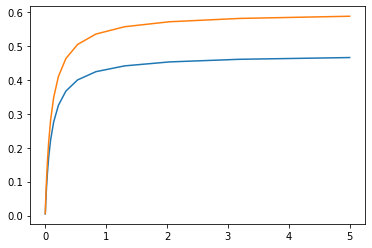

In [4]:
pfk_enzyme = network.reaction_vector({pfk: 0.01})
fn = lambda state: ck.dstate_dt(state, pfk_enzyme)
vfn = jax.vmap(fn)
states = substrate_velocity_state(network, kbm('Fru.D.6P'), min_conc=1e-3, max_conc=5, other_concs={kbm('atp'): 1})
dstate_dt = vfn(states)

s_range = states[:, network.reactant_index(kbm('Fru.D.6P'))]
v_result = dstate_dt[:, network.reactant_index(kbm('Fru.D.bis16'))]

plt.plot(s_range, v_result)
plt.plot(s_range, 0.01 * 60 * s_range / (s_range + 0.1))
plt.show()

- Not full strength because of substrate inhibition. So, working as intended.

#### S = ATP

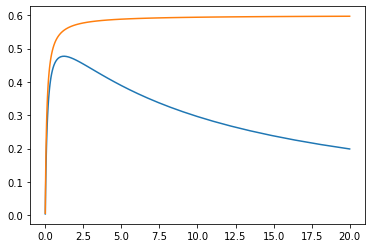

In [5]:
states = substrate_velocity_state(network, kbm('atp'), min_conc=1e-3, max_conc=20, other_concs={kbm('Fru.D.6P'): 100}, num_assays=101)
dstate_dt = vfn(states)

s_range = states[:, network.reactant_index(kbm('atp'))]
v_result = dstate_dt[:, network.reactant_index(kbm('Fru.D.bis16'))]

plt.plot(s_range, v_result)
plt.plot(s_range, 0.01 * 60 * s_range / (s_range + 0.1))
plt.show()

Substrate inhibition in action

### PGI V vs S
- S = G6P
- S = F6P (reverse)

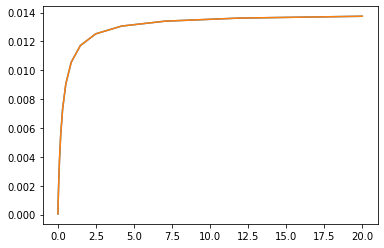

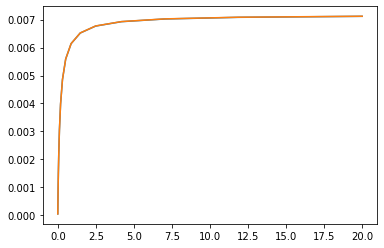

In [6]:
states = substrate_velocity_state(network, kbm('Glc.D.6P'), min_conc=1e-3, max_conc=20)
fn = lambda state: ck.dstate_dt(state, network.reaction_vector({pgi: 0.01}))
vfn = jax.vmap(fn)
dstate_dt = vfn(states)

s_range = states[:, network.reactant_index(kbm('Glc.D.6P'))]
v_result = dstate_dt[:, network.reactant_index(kbm('Fru.D.6P'))]

plt.plot(s_range, 0.01 * 1.394 * s_range / (s_range + 0.28))
plt.plot(s_range, v_result)
plt.show()

states = substrate_velocity_state(network, kbm('Fru.D.6P'), min_conc=1e-3, max_conc=20)
dstate_dt = vfn(states)

s_range = states[:, network.reactant_index(kbm('Fru.D.6P'))]
v_result = -dstate_dt[:, network.reactant_index(kbm('Glc.D.6P'))]

plt.plot(s_range, 0.01 * 0.717 * s_range / (s_range + 0.147))
plt.plot(s_range, v_result)
plt.show()

## Find Steady State in a 2-reaction System
- F6P is the only variable; everything else is as given

In [11]:
def ss_residual_fn(concs, enzymes, internals):
    state = jnp.asarray(network.reactant_vector(concs))
    enzyme_concs = jnp.asarray(network.reaction_vector(enzymes))
    var_idx = np.array([network.reactant_index(mol) for mol in internals])

    def ss_residual(x):
        dydt = ck.dstate_dt(state.at[var_idx].set(x), enzyme_concs)
        return dydt[var_idx]
    
    return ss_residual


In [15]:
fn = ss_residual_fn(concs, {pgi: 0.01, pfk: 0.01}, [kbm('Fru.D.6P')])
ss = scipy.optimize.least_squares(
    fun=jax.jit(fn),
    x0 = jnp.array([concs[kbm('Fru.D.6P')]]),
    jac=jax.jit(jax.jacfwd(fn))
)
print(f'Steady state [F6P] = {ss.x}, with residual dy/dt = {ss.fun}')


Steady state [F6P] = [0.07571588], with residual dy/dt = [4.12832268e-12]


### Steady state [F6P] as a function of [PGI] with [PFK] constant

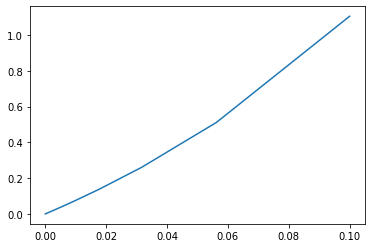

In [25]:
min_conc = 1e-6  # 1 nM = 1 per cell
max_conc = 0.1  # 1 mM = 1e5 per cell
num_assays = 21
pgi_range = jnp.exp(jnp.linspace(jnp.log(min_conc), jnp.log(max_conc), num_assays))

results = []
residuals = []
for pgi_conc in pgi_range:
    fn = ss_residual_fn(concs, {pgi: pgi_conc, pfk: 0.01}, [kbm('Fru.D.6P')])
    ss = scipy.optimize.least_squares(
        fun=jax.jit(fn),
        x0 = jnp.array([concs[kbm('Fru.D.6P')]]),
        jac=jax.jit(jax.jacfwd(fn))
    )

    results.append(ss.x[0])
    residuals.append(ss.fun[0])

plt.plot(pgi_range, results)
plt.show()

In [26]:
residuals

[6.00515669545565e-12,
 1.8990180242746624e-11,
 6.005226485507141e-11,
 1.8990017349332318e-10,
 6.00503613140327e-10,
 1.8988771361579918e-09,
 6.004304304775977e-09,
 1.8984601204630126e-08,
 1.1940291420528548e-14,
 1.1932607137631057e-13,
 1.191886812770132e-12,
 1.1894454388441944e-11,
 1.1851130818883726e-10,
 1.177437523782604e-09,
 1.163878856052375e-08,
 4.3841666408361846e-14,
 4.128320948981745e-12,
 3.7033382610518473e-10,
 3.037360396529465e-08,
 1.7542522989799636e-11,
 1.456647302777725e-11]